In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
import warnings
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
plt.rcParams['figure.dpi'] = 100
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
warnings.filterwarnings("ignore")

In [72]:
tran_data = pd.read_csv(r"E:/python/data/训练赛/租金预测/rent_forecast/train.csv")
display(tran_data.tail())
pre_data = pd.read_csv(r'E:/python/data/训练赛/租金预测/rent_forecast/test_noLabel.csv')
pre_data.head()

ID    位置  出租方式     区  卧室数量  卫的数量  厅的数量  地铁站点  地铁线路   小区名  \
196534  196534  71.0   NaN  12.0     4     2     1   3.6   5.0  5037   
196535  196535  28.0   NaN   7.0     3     2     2   2.0   2.0  2544   
196536  196536  86.0   NaN   9.0     1     1     0   1.0   1.0  6064   
196537  196537  33.0   NaN   3.0     1     1     0   NaN   NaN  5952   
196538  196538  59.0   NaN   6.0     2     1     1   5.7   3.0  2495   

         小区房屋出租数量  居住状态        总楼层 房屋朝向        房屋面积  时间  楼层  装修情况         距离  \
196534   78.12500   NaN  56.363636   西南  238.331678   3   1   NaN  26.333333   
196535   15.62500   NaN  30.909091   东南  162.197948   3   0   NaN  85.166667   
196536  218.75000   NaN  38.181818    南   41.310824   3   1   NaN  23.416667   
196537   46.87500   NaN  38.181818    西   44.687190   3   1   NaN        NaN   
196538   27.34375   NaN  29.090909    南  103.095002   3   2   NaN  78.666667   

            Label  
196534  17.487267  
196535   5.602716  
196536   2.886248  
196537   2.207131  
196538  10.696095

ID    位置  出租方式     区  卧室数量  卫的数量  厅的数量  地铁站点  地铁线路   小区名   小区房屋出租数量  \
0  196539   5.0   1.0  10.0     2     1     1   NaN   NaN  6011  382.81250   
1  196540   0.0   NaN   3.0     2     1     1   NaN   NaN  1697  152.34375   
2  196541   9.0   NaN  10.0     3     2     2   7.4   4.0   754  207.03125   
3  196542  96.0   NaN   6.0     2     1     1   1.7   5.0  1285   11.71875   
4  196543  61.0   NaN   6.0     2     1     1  11.4   3.0  4984   35.15625   

   居住状态        总楼层 房屋朝向        房屋面积  时间  楼层  装修情况         距离  
0   3.0  60.000000    东   71.168487   4   1   6.0        NaN  
1   NaN  47.272727    东   74.478649   4   1   NaN        NaN  
2   NaN  70.909091   东南  140.681893   4   2   NaN  40.083333  
3   NaN   9.090909    南   89.374379   4   0   NaN  38.416667  
4   NaN  21.818182   东南   86.064217   4   1   NaN  59.833333

In [67]:
_train_data = tran_data.copy()
del _train_data['Label']
total_data = pd.concat([_train_data,pre_data],ignore_index=1)

In [68]:
def count_nan(data):
    display(data.isna().sum())

# count_nan(tran_data)
# count_nan(pre_data)
count_nan(total_data)

ID               0
位置              41
出租方式        223617
区               41
卧室数量             0
卫的数量             0
厅的数量             0
地铁站点        134546
地铁线路        134546
小区名              0
小区房屋出租数量      1023
居住状态        228197
总楼层              0
房屋朝向             0
房屋面积             0
时间               0
楼层               0
装修情况        230119
距离          134546
dtype: int64

In [88]:
def One_Hot_Encoder(_data,cloumns):
    for i in cloumns:
        if i in _data.columns:
            arr = ['东南', '东', '南', '东北', '西南', '北', '西北', '西']
            encoding = pd.DataFrame(data=np.zeros((_data.shape[0],len(arr))),columns=arr)
            count = 0
            for j in _data[i].tolist():
                s = j.split(sep=' ')
                for k in s:
                    encoding.loc[count,k] = 1
                count+=1
            _data = pd.merge(_data,encoding,left_index=True,right_index=True,how='inner')
            del _data[i]
    return _data
# tran_data = One_Hot_Encoder(tran_data.copy(),['房屋朝向'])
# pre_data = One_Hot_Encoder(pre_data.copy(),['房屋朝向'])
# tran_data.head()
# pre_data.head()
__total_data = One_Hot_Encoder(total_data.copy(),['房屋朝向'])


In [117]:
_total_data = __total_data.copy()
data=_total_data.groupby('小区名')[['位置','区','地铁站点','地铁线路','小区房屋出租数量','距离']].median()
data = data.fillna(value={'位置':0,'区':-1,'地铁站点':0,'地铁线路':0,'距离':-1,'小区房屋出租数量':_total_data['小区房屋出租数量'].median()})
data.loc[0]

位置          59.000000
区            6.000000
地铁站点         5.700000
地铁线路         3.000000
小区房屋出租数量     7.812500
距离          47.833333
Name: 0, dtype: float64

In [118]:
for c in data.columns:
    print(c)
    for i in _total_data.index:
        try:
            if np.isnan(_total_data.loc[i,c]):
                n=_total_data.loc[i,'小区名']
                _total_data.loc[i,c]=data.loc[n,c]
        except Exception:
            pass
        continue

位置
区
地铁站点
地铁线路
小区房屋出租数量
距离


In [119]:
values = {'出租方式':tran_data['出租方式'].mean(),'装修情况':tran_data['装修情况'].mean(),
         '居住状态':tran_data['居住状态'].mode()}
# tran_data.fillna(value=values)
# pre_data.fillna(value=values)
total_data = _total_data.fillna(value=values)
total_data

ID     位置      出租方式     区  卧室数量  卫的数量  厅的数量  地铁站点  地铁线路   小区名  \
0            0  118.0  0.900289  11.0     1     1     1   4.0   2.0  3072   
1            1  100.0  0.900289  10.0     1     0     0   5.8   4.0  3152   
2            2  130.0  0.900289  12.0     2     2     1   3.7   5.0  5575   
3            3   90.0  0.900289   7.0     3     2     2   6.3   2.0  3103   
4            4   31.0  0.900289   3.0     2     1     1   0.0   0.0  5182   
...        ...    ...       ...   ...   ...   ...   ...   ...   ...   ...   
252813  252813  133.0  0.900289   8.0     2     1     2   0.0   0.0  6586   
252814  252814   55.0  0.900289  11.0     3     2     1   4.0   2.0  4561   
252815  252815  142.0  0.900289   9.0     2     1     1   1.6   5.0   607   
252816  252816   79.0  0.900289   6.0     2     1     1   1.7   5.0  6358   
252817  252817   40.0  0.900289   1.0     1     1     1   6.8   5.0  4422   

        ...      装修情况         距离   东南    东    南   东北   西南    北   西北    西  
0       ...  3.589228  76.416667  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1       ...  3.589228  70.916667  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
2       ...  3.589228  57.250000  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3       ...  3.589228  65.833333  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
4       ...  3.589228  -1.000000  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  
...     ...       ...        ...  ...  ...  ...  ...  ...  ...  ...  ...  
252813  ...  3.589228  -1.000000  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
252814  ...  3.589228  22.583333  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
252815  ...  3.589228  94.750000  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
252816  ...  3.589228  61.416667  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
252817  ...  3.589228  27.500000  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[252818 rows x 26 columns]

In [120]:
def del_column(_data,columns):
    for i in columns:
        if i in _data.columns:
            del _data[i]
    return _data
del_columns =  ['ID','房屋朝向']
_X = del_column(_total_data.copy(),del_columns)
X = _X.loc[:196538,:]
Y = tran_data['Label']
test_X = _X.loc[196539:,:]
X_train, X_test,Y_train,Y_test = train_test_split(X, Y,test_size=0.2)
test_data = del_column(pre_data.copy(),del_columns)


In [6]:
X.to_csv(r'E:/python/data/训练赛/租金预测/rent_forecast/temp.csv',index=False)

In [121]:
xgb = XGBRegressor(gamma= 3.0, learning_rate= 0.65)
xgb.fit(X_train, Y_train)
xgb.score(X_test, Y_test)
mean_squared_error(xgb.predict(X_test),Y_test)

4.244033393153077

In [123]:
lgbm = LGBMRegressor()
lgbm.fit(X_train, Y_train)
# lgbm.score(X_test, Y_test)
mean_squared_error(lgbm.predict(X_test),Y_test)

7.18643473581857

In [126]:
catbost = CatBoostRegressor()
catbost.fit(X_train, Y_train)
# lgbm.score(X_test, Y_test)
mean_squared_error(catbost.predict(X_test),Y_test)

Learning rate set to 0.096025
0:	learn: 6.0669407	total: 15.7ms	remaining: 15.7s
1:	learn: 5.8226146	total: 30.3ms	remaining: 15.1s
2:	learn: 5.6007493	total: 44.8ms	remaining: 14.9s
3:	learn: 5.4127809	total: 59.9ms	remaining: 14.9s
4:	learn: 5.2426813	total: 74.1ms	remaining: 14.7s
5:	learn: 5.0861145	total: 88.4ms	remaining: 14.6s
6:	learn: 4.9526441	total: 103ms	remaining: 14.6s
7:	learn: 4.8392131	total: 117ms	remaining: 14.5s
8:	learn: 4.7381924	total: 131ms	remaining: 14.4s
9:	learn: 4.6512281	total: 143ms	remaining: 14.2s
10:	learn: 4.5660466	total: 157ms	remaining: 14.1s
11:	learn: 4.4921295	total: 171ms	remaining: 14s
12:	learn: 4.4260751	total: 186ms	remaining: 14.1s
13:	learn: 4.3668763	total: 200ms	remaining: 14.1s
14:	learn: 4.3112740	total: 216ms	remaining: 14.2s
15:	learn: 4.2597940	total: 229ms	remaining: 14.1s
16:	learn: 4.2118157	total: 243ms	remaining: 14s
17:	learn: 4.1710272	total: 255ms	remaining: 13.9s
18:	learn: 4.1302320	total: 269ms	remaining: 13.9s
19:	learn

166:	learn: 2.9295327	total: 2.38s	remaining: 11.9s
167:	learn: 2.9263434	total: 2.4s	remaining: 11.9s
168:	learn: 2.9208921	total: 2.41s	remaining: 11.9s
169:	learn: 2.9176846	total: 2.43s	remaining: 11.9s
170:	learn: 2.9160297	total: 2.44s	remaining: 11.8s
171:	learn: 2.9121062	total: 2.45s	remaining: 11.8s
172:	learn: 2.9080548	total: 2.47s	remaining: 11.8s
173:	learn: 2.9063963	total: 2.48s	remaining: 11.8s
174:	learn: 2.9034948	total: 2.49s	remaining: 11.8s
175:	learn: 2.9005217	total: 2.51s	remaining: 11.7s
176:	learn: 2.8971384	total: 2.52s	remaining: 11.7s
177:	learn: 2.8934095	total: 2.53s	remaining: 11.7s
178:	learn: 2.8914947	total: 2.55s	remaining: 11.7s
179:	learn: 2.8884020	total: 2.56s	remaining: 11.7s
180:	learn: 2.8840994	total: 2.58s	remaining: 11.7s
181:	learn: 2.8815871	total: 2.59s	remaining: 11.7s
182:	learn: 2.8788432	total: 2.6s	remaining: 11.6s
183:	learn: 2.8761426	total: 2.62s	remaining: 11.6s
184:	learn: 2.8738946	total: 2.63s	remaining: 11.6s
185:	learn: 2.

327:	learn: 2.5964095	total: 4.61s	remaining: 9.44s
328:	learn: 2.5954376	total: 4.62s	remaining: 9.43s
329:	learn: 2.5924162	total: 4.64s	remaining: 9.41s
330:	learn: 2.5918723	total: 4.65s	remaining: 9.4s
331:	learn: 2.5890267	total: 4.66s	remaining: 9.38s
332:	learn: 2.5878627	total: 4.68s	remaining: 9.37s
333:	learn: 2.5864069	total: 4.69s	remaining: 9.35s
334:	learn: 2.5850693	total: 4.7s	remaining: 9.34s
335:	learn: 2.5837910	total: 4.72s	remaining: 9.32s
336:	learn: 2.5821117	total: 4.73s	remaining: 9.31s
337:	learn: 2.5809221	total: 4.74s	remaining: 9.29s
338:	learn: 2.5796265	total: 4.76s	remaining: 9.28s
339:	learn: 2.5788796	total: 4.77s	remaining: 9.26s
340:	learn: 2.5771976	total: 4.79s	remaining: 9.25s
341:	learn: 2.5765411	total: 4.8s	remaining: 9.23s
342:	learn: 2.5742888	total: 4.81s	remaining: 9.22s
343:	learn: 2.5722493	total: 4.83s	remaining: 9.2s
344:	learn: 2.5677123	total: 4.84s	remaining: 9.19s
345:	learn: 2.5668420	total: 4.85s	remaining: 9.17s
346:	learn: 2.56

488:	learn: 2.4017729	total: 6.84s	remaining: 7.14s
489:	learn: 2.4007042	total: 6.85s	remaining: 7.13s
490:	learn: 2.4000182	total: 6.87s	remaining: 7.12s
491:	learn: 2.3982853	total: 6.88s	remaining: 7.11s
492:	learn: 2.3973566	total: 6.9s	remaining: 7.09s
493:	learn: 2.3962890	total: 6.91s	remaining: 7.08s
494:	learn: 2.3955802	total: 6.93s	remaining: 7.07s
495:	learn: 2.3943673	total: 6.94s	remaining: 7.05s
496:	learn: 2.3931382	total: 6.96s	remaining: 7.04s
497:	learn: 2.3923588	total: 6.97s	remaining: 7.02s
498:	learn: 2.3914009	total: 6.98s	remaining: 7.01s
499:	learn: 2.3905240	total: 7s	remaining: 7s
500:	learn: 2.3897587	total: 7.01s	remaining: 6.99s
501:	learn: 2.3883132	total: 7.03s	remaining: 6.97s
502:	learn: 2.3876090	total: 7.04s	remaining: 6.96s
503:	learn: 2.3870759	total: 7.06s	remaining: 6.95s
504:	learn: 2.3856543	total: 7.07s	remaining: 6.93s
505:	learn: 2.3841569	total: 7.08s	remaining: 6.92s
506:	learn: 2.3833127	total: 7.1s	remaining: 6.9s
507:	learn: 2.3821283

647:	learn: 2.2725886	total: 9.22s	remaining: 5.01s
648:	learn: 2.2714958	total: 9.24s	remaining: 5s
649:	learn: 2.2711976	total: 9.25s	remaining: 4.98s
650:	learn: 2.2707486	total: 9.27s	remaining: 4.97s
651:	learn: 2.2700969	total: 9.28s	remaining: 4.95s
652:	learn: 2.2696918	total: 9.29s	remaining: 4.94s
653:	learn: 2.2694830	total: 9.31s	remaining: 4.92s
654:	learn: 2.2688952	total: 9.32s	remaining: 4.91s
655:	learn: 2.2683840	total: 9.34s	remaining: 4.9s
656:	learn: 2.2681285	total: 9.35s	remaining: 4.88s
657:	learn: 2.2676779	total: 9.37s	remaining: 4.87s
658:	learn: 2.2673981	total: 9.38s	remaining: 4.85s
659:	learn: 2.2669594	total: 9.39s	remaining: 4.84s
660:	learn: 2.2661916	total: 9.41s	remaining: 4.83s
661:	learn: 2.2655681	total: 9.43s	remaining: 4.81s
662:	learn: 2.2649561	total: 9.44s	remaining: 4.8s
663:	learn: 2.2647468	total: 9.45s	remaining: 4.78s
664:	learn: 2.2641434	total: 9.47s	remaining: 4.77s
665:	learn: 2.2634806	total: 9.48s	remaining: 4.75s
666:	learn: 2.262

807:	learn: 2.1739312	total: 11.6s	remaining: 2.76s
808:	learn: 2.1732591	total: 11.6s	remaining: 2.75s
809:	learn: 2.1728517	total: 11.7s	remaining: 2.73s
810:	learn: 2.1726032	total: 11.7s	remaining: 2.72s
811:	learn: 2.1724307	total: 11.7s	remaining: 2.71s
812:	learn: 2.1714793	total: 11.7s	remaining: 2.69s
813:	learn: 2.1711830	total: 11.7s	remaining: 2.68s
814:	learn: 2.1705619	total: 11.7s	remaining: 2.67s
815:	learn: 2.1704350	total: 11.8s	remaining: 2.65s
816:	learn: 2.1695295	total: 11.8s	remaining: 2.64s
817:	learn: 2.1693705	total: 11.8s	remaining: 2.63s
818:	learn: 2.1692277	total: 11.8s	remaining: 2.61s
819:	learn: 2.1684789	total: 11.8s	remaining: 2.6s
820:	learn: 2.1677439	total: 11.9s	remaining: 2.59s
821:	learn: 2.1670894	total: 11.9s	remaining: 2.57s
822:	learn: 2.1663434	total: 11.9s	remaining: 2.56s
823:	learn: 2.1658872	total: 11.9s	remaining: 2.54s
824:	learn: 2.1655424	total: 11.9s	remaining: 2.53s
825:	learn: 2.1648233	total: 12s	remaining: 2.52s
826:	learn: 2.1

973:	learn: 2.0902969	total: 14.8s	remaining: 394ms
974:	learn: 2.0897060	total: 14.8s	remaining: 379ms
975:	learn: 2.0893132	total: 14.8s	remaining: 364ms
976:	learn: 2.0887839	total: 14.8s	remaining: 349ms
977:	learn: 2.0886307	total: 14.8s	remaining: 334ms
978:	learn: 2.0884300	total: 14.9s	remaining: 319ms
979:	learn: 2.0883655	total: 14.9s	remaining: 304ms
980:	learn: 2.0878636	total: 14.9s	remaining: 288ms
981:	learn: 2.0872079	total: 14.9s	remaining: 273ms
982:	learn: 2.0866252	total: 14.9s	remaining: 258ms
983:	learn: 2.0859336	total: 14.9s	remaining: 243ms
984:	learn: 2.0857886	total: 15s	remaining: 228ms
985:	learn: 2.0848111	total: 15s	remaining: 213ms
986:	learn: 2.0841284	total: 15s	remaining: 198ms
987:	learn: 2.0837050	total: 15s	remaining: 182ms
988:	learn: 2.0831732	total: 15s	remaining: 167ms
989:	learn: 2.0824790	total: 15.1s	remaining: 152ms
990:	learn: 2.0822359	total: 15.1s	remaining: 137ms
991:	learn: 2.0818927	total: 15.1s	remaining: 122ms
992:	learn: 2.0814787	

5.297764659365185

In [122]:
learning_rate = [0.6,0.65]
gamma = [3.0,2.9]
_xgb = XGBRegressor()
# _xgb.fit(X, Y)
glf = GridSearchCV(_xgb,param_grid={'learning_rate':learning_rate,'gamma':gamma},scoring='neg_mean_squared_error')
glf.fit(X,Y)
Label = glf.best_estimator_.predict(test_X)
display(glf.best_params_)
glf.best_score_


{'gamma': 3.0, 'learning_rate': 0.65}

-4.464918410279077

In [124]:
submit = pre_data['ID'].copy()
submit = pd.DataFrame(data = list(zip(submit.tolist(),Label)),columns=['ID', 'Label'])
submit.set_index('ID')

Label
ID               
196539   4.162991
196540   6.113903
196541  14.092904
196542   6.137066
196543   6.481652
...           ...
252813   4.236765
252814  14.272824
252815   6.564347
252816  11.800523
252817   4.629791

[56279 rows x 1 columns]

In [125]:
submit.to_csv(r'E:/python/data/训练赛/租金预测/rent_forecast/submit.csv',index=False)

<BarContainer object of 25 artists>

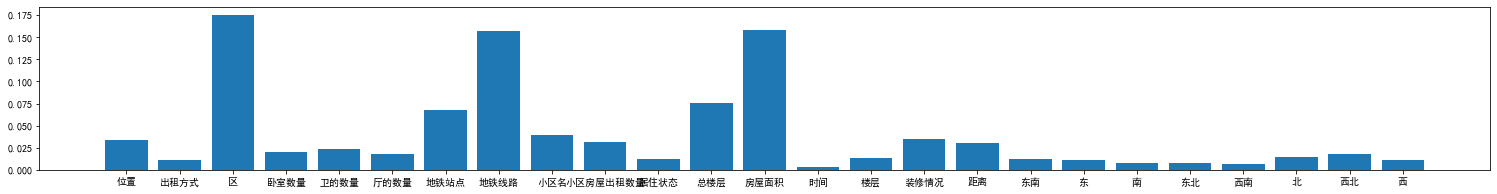

In [138]:
plt.figure(figsize=(26,3))
plt.bar(X.columns,glf.best_estimator_.feature_importances_)